In [45]:
#https://medium.com/@ronnyml/website-screenshot-generator-with-python-593d6ddb56cb
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
from selenium import *
import time
DRIVER = 'chromedriver'
driver = webdriver.Chrome('/Users/jskycak/automation/chromedriver')
driver.get('https://cms8.remilon.com/login')

username = driver.find_element_by_name("username")
password = driver.find_element_by_name("password")

username.send_keys("jskycak")
password.send_keys("")

driver.find_element_by_class_name("btn").click()

driver.get('https://cms8.remilon.com/work#!/available')
time.sleep(5)
screenshot = driver.save_screenshot('my_screenshot.png')
driver.quit()

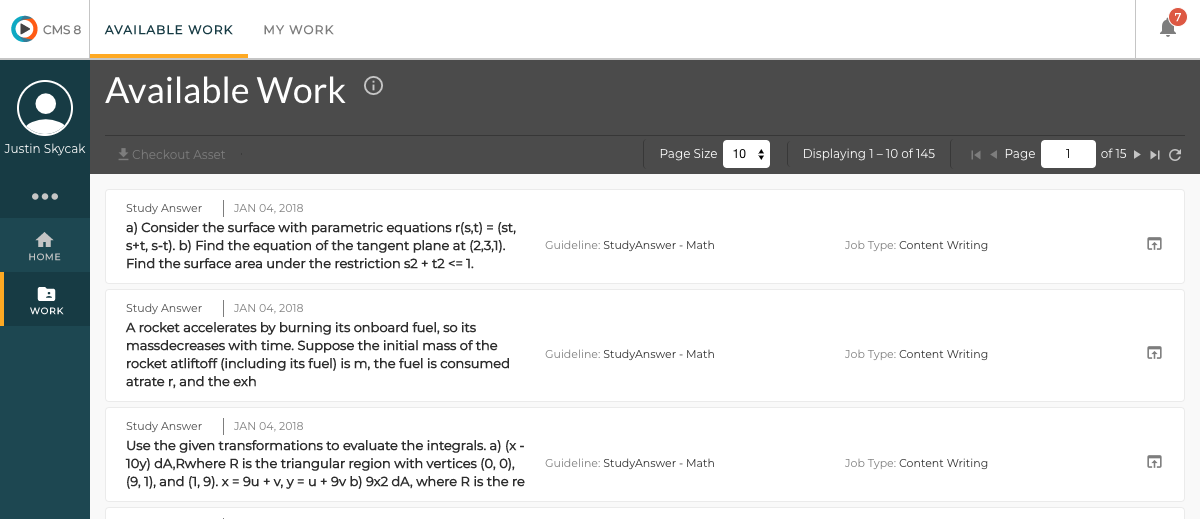

In [46]:
from IPython.display import Image
Image(filename='my_screenshot.png') 